# 7. Feladatsor: megoldások

*(Spline, trigonometrikus polinom, interpolációból származtatható integrál- és deriváltformulák, egyszerű kvadratúrák)*

### P1. Feladat

Írjunk programot, ami adott $x$ és $y$ -pontokat és az ott felveendő értékeket tartalmazó- **három hosszú** vektorokra köbös spline-ot illeszt, a "természetes" (végpontokban eltűnő második derivált) peremfeltétellel. Feltehetjük, hogy a pontok egymást egyenlő távolságban követik, hogy könnyebb legyen leírni a megoldást.

In [7]:
import numpy as np

from typing import Callable

def spline33(xs: np.array, ys: np.array) -> Callable[[float], float]:
    h = np.diff(xs).mean()

    a = (ys[0] - ys[1] + ys[2] - ys[1])/4
    y0__ = 6*a
    y0_ = (ys[2] - ys[0])/2
    y0 = ys[1]

    def quad(z):
        return y0 + y0_*z + y0__*z**2/2
        
    def p(z):
        return quad(z) + a*z**3

    def q(z):
        return quad(z) - a*z**3

    def spline(z: float) -> float:
        w = (z-xs[1])/h

        return p(w)*(w <= 0) + q(w) * (w > 0)
    
    return spline

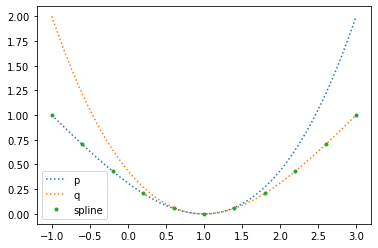

In [31]:
sp = spline33(2 * np.array([-1, 0 ,1]) + 1, np.array([1, 0, 1]))

import matplotlib.pyplot as plt

ts = np.linspace(-1, 3, 101)
plt.plot(ts, ((ts-1)/2)**2*3/2 + ((ts-1)/2)**3/2, label='p', ls='dotted')
plt.plot(ts, ((ts-1)/2)**2*3/2 - ((ts-1)/2)**3/2, label='q', ls='dotted')
plt.plot(ts[::10], sp(ts)[::10], '.', label="spline")
plt.legend()

### P2*. Feladat

Írjunk programot, ami adott $x$ és $y$ -pontokat és az ott felveendő értékeket tartalmazó- vektorokra köbös spline-ot illeszt, pl. a "természetes" (végpontokban eltűnő második derivált) peremfeltétellel. Ha szeretnénk, feltehetjük, hogy az alappontjaink egyenletesek.

In [ ]:
# hosszu

### P3. Feladat

Írjunk programot, ami adott $x$ és $y$ -pontokat és az ott felveendő értékeket tartalmazó- vektorokra ráilleszti a kettes norma szerinti legjobb trigonometrikus polinomot (az $N$ legyen bemeneti paraméter).

Alkalmazzuk ezt a programot akkor, ha az $x, y$ vektorok az
$$
[0, 2\pi] \ni x \mapsto \frac{1}{\pi^2} \left(\pi - |\pi-x|\right)
$$jelből származó egyenletes mintavételezés eredményét tartalmazzák.

In [9]:
def A(xs: np.array, N: int) -> np.matrix:
    nxs = np.arange(1, N+1).reshape((-1, 1)) * xs 

    return np.matrix(
        np.vstack((
            np.ones_like(xs),
            np.cos(nxs),
            np.sin(nxs)
        ))
    ).T

def p3(xs: np.array, ys: np.array, N: int) -> (np.array, np.array):
    a = A(xs, N)
    coefficients = np.linalg.solve(a.T @ a, a.T @ ys.reshape((-1, 1)))

    ys_projected = a @ coefficients
    return coefficients, ys_projected

In [51]:
xs=[0.1,0.2,0.3,0.4]
nxs = np.arange(1, 8).reshape((-1, 1)) * np.array(xs)
print(nxs)

G=np.matrix(np.vstack((
                np.ones_like(xs),
                np.cos(nxs),
                np.sin(nxs)
            )))
print(G)

[[0.1 0.2 0.3 0.4]
 [0.2 0.4 0.6 0.8]
 [0.3 0.6 0.9 1.2]
 [0.4 0.8 1.2 1.6]
 [0.5 1.  1.5 2. ]
 [0.6 1.2 1.8 2.4]
 [0.7 1.4 2.1 2.8]]
[[ 1.          1.          1.          1.        ]
 [ 0.99500417  0.98006658  0.95533649  0.92106099]
 [ 0.98006658  0.92106099  0.82533561  0.69670671]
 [ 0.95533649  0.82533561  0.62160997  0.36235775]
 [ 0.92106099  0.69670671  0.36235775 -0.02919952]
 [ 0.87758256  0.54030231  0.0707372  -0.41614684]
 [ 0.82533561  0.36235775 -0.22720209 -0.73739372]
 [ 0.76484219  0.16996714 -0.5048461  -0.94222234]
 [ 0.09983342  0.19866933  0.29552021  0.38941834]
 [ 0.19866933  0.38941834  0.56464247  0.71735609]
 [ 0.29552021  0.56464247  0.78332691  0.93203909]
 [ 0.38941834  0.71735609  0.93203909  0.9995736 ]
 [ 0.47942554  0.84147098  0.99749499  0.90929743]
 [ 0.56464247  0.93203909  0.97384763  0.67546318]
 [ 0.64421769  0.98544973  0.86320937  0.33498815]]


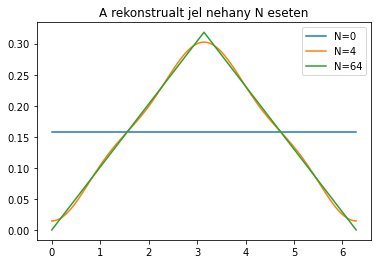

In [10]:
xs = np.linspace(0, 2*np.pi, 101)
ys = 1/np.pi**2 *(np.pi - abs(np.pi - xs))

for N in [0, 4, 64]:
    cs, ys_proj = p3(xs, ys, N)
    plt.title('A rekonstrualt jel nehany N eseten')
    plt.plot(xs, ys_proj, label=f'N={N}')

plt.legend()
plt.show()

### P4. Feladat

Írjunk programot, ami kiszámolja egy adott kvadratúra rendjét. Próbáljuk is ki néhány formulán (pl. azokon, amiket levezettünk).

In [11]:
from itertools import takewhile

def kvadratura_rend(bs: np.array, cs: np.array) -> int:
    # bs: súlyok
    # cs: alappontok ([0,1]-ből)

    s = len(bs)
    # max rend = 2s, elég addig nézni
    # sum b_j c_j^(q-1)
    cond_lhs = np.array(bs) @ np.array(cs).reshape((-1, 1)) ** np.arange(2*s) 
    # 1/q
    cond_rhs = 1 / np.arange(1, 2*s+1)
    
    cond_errs = np.abs(cond_lhs - cond_rhs).flatten()
    
    return sum(1 for _ in takewhile(lambda e: e <= 1e-14, cond_errs))

In [12]:
kvadratura_rend([1], [1])

1

In [13]:
kvadratura_rend([1],[1/2])

2

In [14]:
kvadratura_rend(np.array([1,4,1])/6, np.array([0, 1/2, 1]))

4

## Monte-Carlo-integrálás

**Ötlet:** Az alappontjainkat választhatjuk akár véletlenszerűen is.

Ismeretes, hogy ha $X$ egy valószínűségi változó, mely $\rho$ sűrűségfüggvénye a $[0,1]$-re koncentrált, akkor adott mérhető $f$ függvény mellett
$$
\mathbb{E}[f(X)] = \int\limits_0^1 f(x) \rho (x) \, dx.
$$
Látható, hogy ha $\rho = \chi_{[0,1]}$, azaz a $[0,1]$ intervallum indikátorfüggvénye, akkor 
$$
\mathbb{E}[f(X)] = \int\limits_0^1 f(x) \, dx.
$$
Hogyan tudnánk a baloldalon álló kifejezést közelíteni? A nagy számok gyenge törvényével, természetesen!

Sorsoljunk tehát a $[0,1]$-en egyenletes eloszlásból $\xi_j$ értékeket, helyettesítsük ezeket be és vegyük a kapott értékek átlagát:
$$
 \mathbb{E}[f(X)] \approx \frac{1}{N} \sum\limits_{j=1}^N f(\xi_j).
$$


### P5. Feladat

Írjunk programot, ami ezzel a megközelítéssel dolgozva határozza meg egy $[0,1]$ intervallumon vett intergál közelítő-értékét. Próbáljuk is ki ezt, például az $x^4$ függvényre. Ábrázoljuk hibákat log-log ábrán és fogalmazzunk meg sejtést arról, hogy kb. hányszorosára változik a hiba, ha a sorsolt pontok számát megtízszerezzük.

In [16]:
def mc_int(f: Callable[[np.ndarray], np.ndarray], N: int) -> float:
    return f(np.random.random((N,))).mean()

In [17]:
mc_int(lambda x: x**4, 1000)

0.20242849425893478

In [18]:
N = 7
# sorsolunk egyszer sok szamot
rs = np.random.random((10**N,))
# kiertekeljuk ezeken a fuggvenyunket
frs = rs ** 4
# kiveszunk nehany db (10, 100, 1000, 10_000, 100_000, 1_000_000) ilyen erteket, vesszuk ezek atlagat, 
# majd vesszuk ezen atlag eltereset a tenyleges integral erteketol (0.2)
# mindezt megismeteljuk 10x, es vesszuk az igy kapott erteket atlagait :)
errs = np.array([
    sum(
        abs(frs[j::10**k].mean() - 0.2) 
        for j in range(10)
    )/10
    for k in range(N)
])
errs

array([9.01911428e-05, 1.42806504e-04, 6.47917612e-04, 1.41445292e-03,
       5.41615093e-03, 1.73732047e-02, 6.21824848e-02])

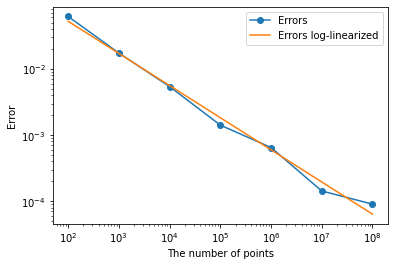

Az egyenes meredeksege (kb.) -0.49, tehat ha 10x annyi pontot veszunk, akkor kb. 0.33-szorosara valtozik a hiba.


In [19]:
log10Ns = np.arange(N+1, 1, -1)

ab = np.polyfit(log10Ns, np.log10(errs), 1)
logerrs_linearized = ab @ np.vstack((log10Ns, np.ones_like(log10Ns)))

plt.loglog(10**log10Ns, errs, 'o-', label='Errors')
plt.loglog(10**log10Ns, 10**logerrs_linearized, label='Errors log-linearized')

plt.xlabel('The number of points')
plt.ylabel('Error')
plt.legend()
plt.show()
print(f"Az egyenes meredeksege (kb.) {np.round(ab[0], 2)}, tehat ha 10x annyi pontot veszunk, akkor kb. {np.round(10**ab[0], 2)}-szorosara valtozik a hiba.")

In [ ]:
# Az elmélet alapján sqrt(n)-es rendet várnánk, 
# azaz 10**(-1/2)-szeresére kéne változnia a hibának amikor 10x annyi pontot veszünk
# ez látszólag ki is jön (bár néha ehhez tíznél több ismétlés átlagát kell nézni), szóval ma nem találtunk ellentmondást a matekban
#
# maga a konvergencia baromi lassú, cserébe csak annyit kellett feltennünk, hogy a függvényünk mérhető
# kellően sima függvényekre sokkal jobbak a hagyományos kvadratúrák